In [1]:
import sys
sys.path.append('/home/luca/GitRepositories/Brancher')

# Brancher for time series analysis

In this tutorial we will show how to write time series models using the symbolic interface of Brancher. For simplicity, we will focus on simple examples with scalar variables. We will cover more complex models with convulutional and LSTM components in more advanced tutorials. Note however that the syntax for specifying those more advanced models is identical to the syntax shown in these simpler examples. Discrete probabilistic time series models are specified by an equation that links the parameters $\boldsymbol{\theta}_t$ of the probability distribution of the current value $\boldsymbol{x}_{t}$ to the previous values of $\boldsymbol{x}$:

$$ 
\boldsymbol{\theta}_t = \boldsymbol{f}(\boldsymbol{x}_{t-1},...,\boldsymbol{x}_{0}) ~,
$$

where $\boldsymbol{f}$ is an arbitrary function. 

# Autoregressive models
Gaussian autoregressive models are among the simplest examples of probabilistic time series models. An AR(1) model is specified by the following equation:

$$ 
\boldsymbol{\mu}_t = b ~ x_{t-1}~,
$$

where $b$ is the (scalar) autoregressive parameter and $\boldsymbol{\mu}_t$ is the mean of a Gaussian distribution with fixed variance $\sigma$. We also need to specify an initial distribution:

$$
x_{t-1} \sim \mathcal{N}(0, \sigma)
$$

Let's write this model in Brancher!


In [2]:
import matplotlib.pyplot as plt
from brancher.standard_variables import NormalVariable
from brancher.variables import ProbabilisticModel

# Model parameters #
T = 100 # Time horizon
b = 0.8 # Autoregressive parameter
sigma = 1. # Standard deviation of the Gaussian input

# Initial distribution
x0 = NormalVariable(0., 1., 'x0')
x = [x0]

# Time series
names = ["x0"]
for t in range(1,T):
    names.append("x{}".format(t))
    x.append(NormalVariable(b*x[t-1], sigma, name=names[t]))
AR_model = ProbabilisticModel(x)

Done! Now we can use the model for generating and plotting some time series.

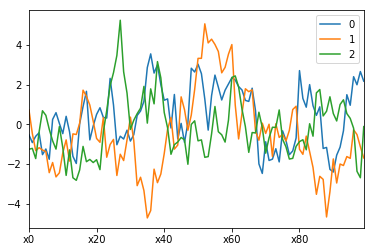

In [3]:
AR_model.get_sample(3)[names].transpose().plot()

## Nonlinear autoregressive models
The flexibility of Brancher allows you to easily specify more complex models. For example, let's now try to construct a more sophisticated autoregressive model with nonlinearities and variable standard deviation:

$$ 
\boldsymbol{\mu}_t = b ~ \tanh{\left( x_{t-1}^3 \right)}~, \\
\boldsymbol{\sigma}_t = 1 + c~x_{t-1}^2~,
$$

In order to implement this model, we need to import the tanh function from the brancher.functions module. This moduls contains every single function present in pytorch, including all the neural network functions that you will probably need for more complex models.

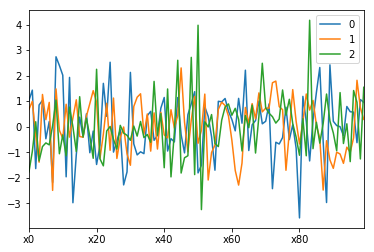

In [4]:
from brancher.functions import tanh

# Model parameters #
T = 100 # Time horizon
b = 0.04 # mean autoregressive parameter
c = 0.1 # SD autoregressive parameter

# Initial distribution
x0 = NormalVariable(0., 1., 'x0')
x = [x0]

# Time series
names = ["x0"]
for t in range(1,T):
    names.append("x{}".format(t))
    x.append(NormalVariable(b*tanh(x[t-1]**3), 1 + c*x[t-1]**2, name=names[t]))
AR_model = ProbabilisticModel(x)

AR_model.get_sample(3)[names].transpose().plot()

## Coupled autoregressive models
We can now couple the value of multiple variables. For example, let's $y_t$ gives the standard deviation of the process $x_t$:

$$ 
\boldsymbol{\mu}^{(y)}_t = b^{(y)} ~ y_{t-1}, \\
\boldsymbol{\mu}^{(x)}_t = b^{(x)} ~ x_{t-1}, \\
\boldsymbol{\sigma}^{(x)}_t = 0.1 + c~y_t^2~.
$$

Text(0.5, 1.0, 'y time series')

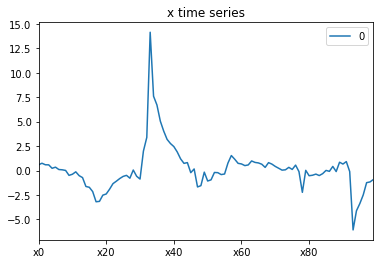

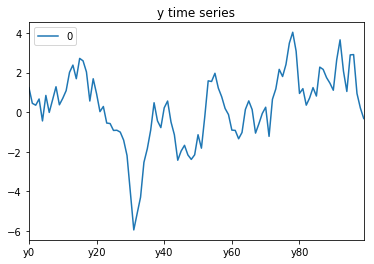

In [5]:
# Model parameters #
T = 100 # Time horizon
b_x = 0.8 # x autoregressive parameter
b_y = 0.99 # y autoregressive parameter
c = 0.2
sigma_y = 1. # Standard deviation of the Gaussian input

# Initial distribution
x0 = NormalVariable(0., 1., 'x0')
x = [x0]
y0 = NormalVariable(0., 1., 'y0')
y = [y0]

# Time series
x_names = ["x0"]
y_names = ["y0"]
for t in range(1,T):
    x_names.append("x{}".format(t))
    y_names.append("y{}".format(t))
    x.append(NormalVariable(b_x*x[t-1], 0.1 + c*y[t-1]**2, name=x_names[t]))
    y.append(NormalVariable(b_y*y[t-1], sigma_y, name=y_names[t]))
    
AR_model = ProbabilisticModel(x + y)

sample = AR_model.get_sample(1)
sample[x_names].transpose().plot()
plt.title("x time series")
sample[y_names].transpose().plot()
plt.title("y time series")

# Inference for time series models

Now that we know how to specify a model, we can use Brancher to perform (variational) Bayesian inference on the latent parameters. For example, let's learn the autoregressive coefficient ($b$) and the noise parameter ($\sigma$) of an autoregressive model. The first step is to specify prior distributions for $b$ and $\sigma$:

In [6]:
from brancher.standard_variables import LogNormalVariable, BetaVariable

# Prior #
sigma = LogNormalVariable(0.8, 0.2, 'nu')
b = BetaVariable(1., 1., 'b')

211

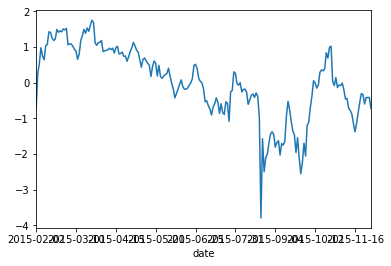

In [7]:
import pandas_datareader.data as data
from datetime import datetime
from scipy.stats import zscore

start = datetime(2015, 2, 1)
end = datetime(2015, 12, 1)

stock_time_series = data.DataReader('F', 'iex', start, end).apply(zscore)["open"]

stock_time_series.plot()
len(stock_time_series)

We can now specify the model as usual

In [8]:
from brancher.standard_variables import DeterministicVariable

T = len(stock_time_series)
x0 = DeterministicVariable(stock_time_series[0], 'x0')
x = [x0]
names = ["x0"]
for t in range(1, T):
    names.append("x{}".format(t))
    x.append(NormalVariable(b*x[t-1], sigma, names[t]))
AR_model = ProbabilisticModel(x)

And we can input the finance time series into our model:

In [9]:
for xt, value in zip(x, stock_time_series):
    xt.observe(value)

We are now ready for performing the inference. The last thing to do is to specify a variational distribution. The simplest thing to do is to "copy" the prior:

/home/luca/GitRepositories/Brancher/brancher/inference.py:61: UserWarning: The inference method was not specified, using the default reverse KL variational inference
  warnings.warn("The inference method was not specified, using the default reverse KL variational inference")
100%|██████████| 150/150 [00:21<00:00,  7.40it/s]


Text(0.5, 1.0, 'Loss')

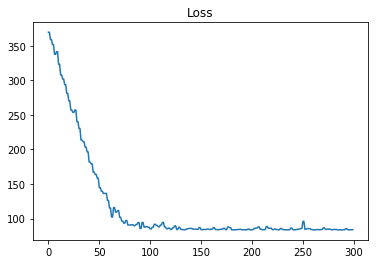

In [10]:
# Variational distribution #
Qnu = LogNormalVariable(0.8, 0.2, "nu", learnable=True)
Qb = BetaVariable(1., 1., "b", learnable=True)
variational_posterior = ProbabilisticModel([Qb, Qnu])
AR_model.set_posterior_model(variational_posterior)

# Inference #
from brancher import inference

inference.perform_inference(AR_model,
                            number_iterations=150,
                            number_samples=50,
                            optimizer='Adam',
                            lr=0.05)
loss_list = AR_model.diagnostics["loss curve"]
plt.plot(loss_list)
plt.title("Loss")

We can finally plot an histogram of the posterior distribution:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3f75394e0>]],
      dtype=object)

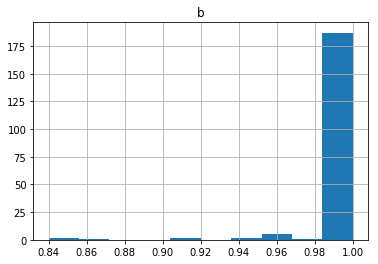

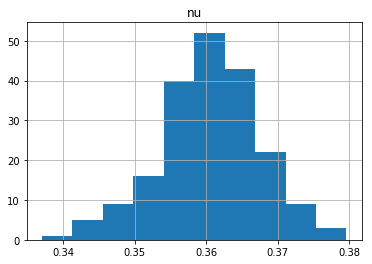

In [18]:
Qb.get_sample(200).hist()
Qnu.get_sample(200).hist()

Note that the autoregressive coeffient is very close to 1. This is consistent with the efficient market hypothesis.

# Forecasting

In [28]:
# Prior #
sigma = LogNormalVariable(0.8, 0.2, 'nu')
b = BetaVariable(1., 1., 'b')

T = len(stock_time_series)
future_T = 30
x0 = DeterministicVariable(stock_time_series[0], 'x0')
x = [x0]
names = ["x0"]
for t in range(1, T + future_T):
    names.append("x{}".format(t))
    x.append(NormalVariable(b*x[t-1], sigma, names[t]))
AR_model = ProbabilisticModel(x)

In [29]:
for xt, value in zip(x[:future_T], stock_time_series):
    xt.observe(value)

In [34]:
# Variational distribution #
Qnu = LogNormalVariable(0.8, 0.2, "nu", learnable=True)
Qb = BetaVariable(1., 1., "b", learnable=True)
beta = DeterministicVariable(0.5, name="beta", learnable=True)
nu = DeterministicVariable(0.5, name="nu", learnable=True)

Qx = []
for t in range(1, future_T):
    print(names[T+t])
    names.append("x{}".format(t))
    Qx.append(NormalVariable(beta*Qx[t-1], nu, names[T+t]))
variational_posterior = ProbabilisticModel([Qb, Qnu] + Qx)
AR_model.set_posterior_model(variational_posterior)

x212


IndexError: list index out of range

In [32]:
len(names)

243